# Comet MLfrom comet_ml import Experiment

In [1]:
# from comet_ml import Experiment

# # Create an experiment with your api key
# experiment = Experiment(
#     api_key="HeNPARP7EmQTxxVRpewzuqm8b",
#     project_name="face-normal-liveness",
#     workspace="ahmadirfaan",
# )

In [2]:
# hyper_params = {
#     "input_size": 224,
#     "num_classes": 2,
#     "batch_size": 32,
#     "learning_rate": 2e-4
# }

In [3]:
# experiment.log_parameters(hyper_params)

# Import Library

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

import PIL

import os

# device = torch.device('cuda:0')
device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=7)

# Dataset and Dataloader

In [6]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

In [7]:
class BoneAgeDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path, images_folder, transform = None):
        self.df = pd.read_csv(csv_path)
        self.images_folder = images_folder
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        filename = str(self.df.iloc[index].id)+".jpg"
        label = torch.from_numpy(np.asarray([self.df.iloc[index].boneage]))
        image = PIL.Image.open(os.path.join(self.images_folder, filename))
        image = image.convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        return image.float(), label.float()

In [8]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize,
])

In [9]:
bs = 64

data_train = BoneAgeDataset("boneage-training-dataset-segmented-1.csv", "../bone-age/boneage-training-dataset/boneage-training-dataset-segmented", transform)

# Split into Train Val
random_seed = 42
torch.manual_seed(random_seed)
val_size = int(len(data_train) * 0.2)
train_size = len(data_train) - (val_size)

train_set, val_set = random_split(
    data_train,
    [train_size, val_size]
)

trainloader = DataLoader(train_set, batch_size=bs)
valloader = DataLoader(val_set, batch_size=bs)

In [10]:
len(train_set), len(val_set)

(9801, 2450)

# Architecture and Config

In [11]:
import torch
from torch import nn
import timm

class BoneAgeModel(nn.Module):
    def __init__(self, pretrained=True):
        super(BoneAgeModel, self).__init__()
        self.backbone = timm.create_model('vit_base_patch16_224', pretrained=pretrained)
        self.n_features = self.backbone.head.in_features
        self.backbone.reset_classifier(0)
        self.fc = nn.Linear(self.n_features, 1)
        
    def freeze(self):
        for param in self.backbone.parameters():
            param.requires_grad = False # Freezing Weight
    
    def unfreeze(self):
        for param in self.backbone.parameters():
            param.requires_grad = True # Unfreezing Weight

    def forward(self, images):
        features = self.backbone(images)              # features = (bs, embedding_size)
        output = self.fc(features)                    # outputs  = (bs, num_classes)
        return output
    
model = BoneAgeModel()
model.to(device)
model.unfreeze()

# Training

In [12]:
from torch.optim import lr_scheduler
from sklearn.metrics import mean_squared_error

In [13]:
# criterion = nn.MSELoss()
def criterion(outputs, targets):
    return torch.sqrt(nn.MSELoss()(outputs.view(-1), targets.view(-1)))
# criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=100, eta_min=1e-6)
# callback = Callback(model, early_stop_patience=4, outdir="model")

In [14]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    scaler = amp.GradScaler()
    
    dataset_size = 0
    running_loss = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, (images, targets) in bar:         
        images = images.to(device, dtype=torch.float)
        targets = targets.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        with amp.autocast(enabled=True):
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss = loss / 1
            
        scaler.scale(loss).backward()
    
        if (step + 1) % 1 == 0:
            scaler.step(optimizer)
            scaler.update()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    
    return epoch_loss

In [15]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [16]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    TARGETS = []
    PREDS = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, (images, targets) in bar:        
        images = images.to(device, dtype=torch.float)
        targets = targets.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        outputs = model(images)
        loss = criterion(outputs, targets)
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        PREDS.append(outputs.view(-1).cpu().detach().numpy())
        TARGETS.append(targets.view(-1).cpu().detach().numpy())
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])   
    
    TARGETS = np.concatenate(TARGETS)
    PREDS = np.concatenate(PREDS)
    val_rmse = mean_squared_error(TARGETS, PREDS, squared=False)
    gc.collect()
    
    val_error = np.abs(PREDS - TARGETS).sum().data    
    val_mae = np.mean(np.abs(TARGETS - PREDS))
    
    val_smape = np.mean(2.0 * np.abs(TARGETS - PREDS) / ((np.abs(TARGETS) + np.abs(PREDS)) +1e-10 ))
    
    return epoch_loss, val_rmse, val_mae, val_smape

In [17]:
import time
import copy
from collections import defaultdict
import gc
from torch.cuda import amp
from tqdm import tqdm

In [18]:
from colorama import Fore, Back, Style
c_ = Fore.CYAN
sr_ = Style.RESET_ALL

In [19]:
def run_training(model, optimizer, scheduler, device, num_epochs):
    
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_rmse = np.inf
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=trainloader, 
                                           device=device, epoch=epoch)
        
        val_epoch_loss, val_epoch_rmse, val_epoch_mae, val_epoch_smape = valid_one_epoch(model, valloader, 
                                                         device=device, 
                                                         epoch=epoch)
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
        history['Valid RMSE'].append(val_epoch_rmse)
        history['Valid MAE'].append(val_epoch_mae)
        history['Valid SMAPE'].append(val_epoch_smape)
        
        print(f'Valid RMSE: {val_epoch_rmse}')
        print(f'Valid MAE: {val_epoch_mae}')
        print(f'Valid SMAPE: {val_epoch_smape}')
        
        if val_epoch_rmse <= best_epoch_rmse:
            print(f"{c_}Validation Loss Improved ({best_epoch_rmse} ---> {val_epoch_rmse})")
            best_epoch_rmse = val_epoch_rmse
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = "RMSE{:.4f}_epoch{:.0f}.bin".format(best_epoch_rmse, epoch)
            torch.save(model.state_dict(), PATH)
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best RMSE: {:.4f}".format(best_epoch_rmse))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

In [20]:
model, history = run_training(model, optimizer, scheduler,
                              device=device,
                              num_epochs=100)

[INFO] Using GPU: A100-SXM4-40GB



  0%|          | 0/154 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
100%|██████████| 39/39 [00:07<00:00,  5.21it/s, Epoch=1, LR=5.67e-5, Valid_Loss=29]  


Valid RMSE: 29.13652801513672
Valid MAE: 21.9808349609375
Valid SMAPE: 0.19881054759025574
Validation Loss Improved (inf ---> 29.13652801513672)



100%|██████████| 39/39 [00:07<00:00,  5.46it/s, Epoch=2, LR=2.56e-6, Valid_Loss=20.7]


Valid RMSE: 20.881223678588867
Valid MAE: 15.93325138092041
Valid SMAPE: 0.1456567943096161
Validation Loss Improved (29.13652801513672 ---> 20.881223678588867)



100%|██████████| 39/39 [00:07<00:00,  5.03it/s, Epoch=3, LR=3.23e-5, Valid_Loss=21.8]


Valid RMSE: 21.875844955444336
Valid MAE: 17.019895553588867
Valid SMAPE: 0.15526898205280304



100%|██████████| 39/39 [00:07<00:00,  5.02it/s, Epoch=4, LR=9.39e-5, Valid_Loss=20]  


Valid RMSE: 20.116453170776367
Valid MAE: 15.561745643615723
Valid SMAPE: 0.14094653725624084
Validation Loss Improved (20.881223678588867 ---> 20.116453170776367)



100%|██████████| 39/39 [00:07<00:00,  5.00it/s, Epoch=5, LR=7.96e-5, Valid_Loss=20.8]


Valid RMSE: 20.982864379882812
Valid MAE: 16.367292404174805
Valid SMAPE: 0.14546650648117065



100%|██████████| 39/39 [00:07<00:00,  5.07it/s, Epoch=6, LR=1.44e-5, Valid_Loss=17.9]


Valid RMSE: 18.043731689453125
Valid MAE: 13.754171371459961
Valid SMAPE: 0.12685376405715942
Validation Loss Improved (20.116453170776367 ---> 18.043731689453125)



100%|██████████| 39/39 [00:07<00:00,  5.26it/s, Epoch=7, LR=1.24e-5, Valid_Loss=17.7]


Valid RMSE: 17.91423797607422
Valid MAE: 13.607196807861328
Valid SMAPE: 0.12404222041368484
Validation Loss Improved (18.043731689453125 ---> 17.91423797607422)



100%|██████████| 39/39 [00:06<00:00,  5.82it/s, Epoch=8, LR=7.7e-5, Valid_Loss=21]  


Valid RMSE: 21.112577438354492
Valid MAE: 16.27059555053711
Valid SMAPE: 0.14634843170642853



100%|██████████| 39/39 [00:07<00:00,  5.00it/s, Epoch=9, LR=9.53e-5, Valid_Loss=25.9]


Valid RMSE: 26.00033187866211
Valid MAE: 20.03360366821289
Valid SMAPE: 0.18175064027309418



100%|██████████| 39/39 [00:07<00:00,  5.10it/s, Epoch=10, LR=3.52e-5, Valid_Loss=17.6]


Valid RMSE: 17.786067962646484
Valid MAE: 13.6590576171875
Valid SMAPE: 0.1249438002705574
Validation Loss Improved (17.91423797607422 ---> 17.786067962646484)



100%|██████████| 39/39 [00:07<00:00,  5.03it/s, Epoch=11, LR=1.88e-6, Valid_Loss=17.4]


Valid RMSE: 17.55076789855957
Valid MAE: 13.36965560913086
Valid SMAPE: 0.12147853523492813
Validation Loss Improved (17.786067962646484 ---> 17.55076789855957)



100%|██████████| 39/39 [00:06<00:00,  5.77it/s, Epoch=12, LR=5.36e-5, Valid_Loss=19.1]


Valid RMSE: 19.150501251220703
Valid MAE: 14.46243667602539
Valid SMAPE: 0.13091592490673065



100%|██████████| 39/39 [00:07<00:00,  5.02it/s, Epoch=13, LR=9.99e-5, Valid_Loss=27.7]


Valid RMSE: 27.819265365600586
Valid MAE: 22.382680892944336
Valid SMAPE: 0.20938599109649658



100%|██████████| 39/39 [00:07<00:00,  5.03it/s, Epoch=14, LR=5.98e-5, Valid_Loss=19.7]


Valid RMSE: 19.80742835998535
Valid MAE: 14.947248458862305
Valid SMAPE: 0.13327902555465698



100%|██████████| 39/39 [00:07<00:00,  5.09it/s, Epoch=15, LR=3.42e-6, Valid_Loss=17.1]


Valid RMSE: 17.17870330810547
Valid MAE: 13.083600044250488
Valid SMAPE: 0.11905481666326523
Validation Loss Improved (17.55076789855957 ---> 17.17870330810547)



100%|██████████| 39/39 [00:07<00:00,  5.01it/s, Epoch=16, LR=2.94e-5, Valid_Loss=17.5]


Valid RMSE: 17.63324546813965
Valid MAE: 13.155683517456055
Valid SMAPE: 0.11987120658159256



100%|██████████| 39/39 [00:07<00:00,  5.01it/s, Epoch=17, LR=9.23e-5, Valid_Loss=19.1]


Valid RMSE: 19.253257751464844
Valid MAE: 14.374244689941406
Valid SMAPE: 0.1315005123615265



100%|██████████| 39/39 [00:07<00:00,  5.03it/s, Epoch=18, LR=8.21e-5, Valid_Loss=19.6]


Valid RMSE: 19.752817153930664
Valid MAE: 15.514937400817871
Valid SMAPE: 0.14028212428092957



100%|██████████| 39/39 [00:07<00:00,  5.13it/s, Epoch=19, LR=1.66e-5, Valid_Loss=16.6]


Valid RMSE: 16.688919067382812
Valid MAE: 12.659167289733887
Valid SMAPE: 0.11744453012943268
Validation Loss Improved (17.17870330810547 ---> 16.688919067382812)



100%|██████████| 39/39 [00:07<00:00,  4.98it/s, Epoch=20, LR=1.05e-5, Valid_Loss=17.4]


Valid RMSE: 17.502239227294922
Valid MAE: 13.189583778381348
Valid SMAPE: 0.12213976681232452



100%|██████████| 39/39 [00:07<00:00,  5.00it/s, Epoch=21, LR=7.43e-5, Valid_Loss=18.3]


Valid RMSE: 18.443891525268555
Valid MAE: 13.91904354095459
Valid SMAPE: 0.12754946947097778



100%|██████████| 39/39 [00:07<00:00,  4.98it/s, Epoch=22, LR=9.65e-5, Valid_Loss=20.3]


Valid RMSE: 20.44588851928711
Valid MAE: 15.789544105529785
Valid SMAPE: 0.1416529268026352



100%|██████████| 39/39 [00:08<00:00,  4.55it/s, Epoch=23, LR=3.82e-5, Valid_Loss=17.4]


Valid RMSE: 17.471763610839844
Valid MAE: 13.417439460754395
Valid SMAPE: 0.12176109850406647



100%|██████████| 39/39 [00:07<00:00,  5.52it/s, Epoch=24, LR=1.39e-6, Valid_Loss=16.6]


Valid RMSE: 16.6484432220459
Valid MAE: 12.478423118591309
Valid SMAPE: 0.11385657638311386
Validation Loss Improved (16.688919067382812 ---> 16.6484432220459)



100%|██████████| 39/39 [00:07<00:00,  5.05it/s, Epoch=25, LR=5.05e-5, Valid_Loss=17.6]


Valid RMSE: 17.70631217956543
Valid MAE: 13.379511833190918
Valid SMAPE: 0.1214820072054863



100%|██████████| 39/39 [00:07<00:00,  5.24it/s, Epoch=26, LR=9.96e-5, Valid_Loss=19.1]


Valid RMSE: 19.209341049194336
Valid MAE: 14.531932830810547
Valid SMAPE: 0.13227708637714386



100%|██████████| 39/39 [00:07<00:00,  5.03it/s, Epoch=27, LR=6.28e-5, Valid_Loss=17.6]


Valid RMSE: 17.659149169921875
Valid MAE: 13.451228141784668
Valid SMAPE: 0.1225050538778305



100%|██████████| 39/39 [00:07<00:00,  4.95it/s, Epoch=28, LR=4.48e-6, Valid_Loss=16.7]


Valid RMSE: 16.83030128479004
Valid MAE: 12.668054580688477
Valid SMAPE: 0.11613330990076065



100%|██████████| 39/39 [00:07<00:00,  4.99it/s, Epoch=29, LR=2.67e-5, Valid_Loss=16.7]


Valid RMSE: 16.795154571533203
Valid MAE: 12.72153091430664
Valid SMAPE: 0.11831481754779816



100%|██████████| 39/39 [00:07<00:00,  5.02it/s, Epoch=30, LR=9.05e-5, Valid_Loss=18.7]


Valid RMSE: 18.870769500732422
Valid MAE: 14.447648048400879
Valid SMAPE: 0.1321742683649063



100%|██████████| 39/39 [00:07<00:00,  5.01it/s, Epoch=31, LR=8.44e-5, Valid_Loss=19.1]


Valid RMSE: 19.19428253173828
Valid MAE: 14.860175132751465
Valid SMAPE: 0.13458330929279327



100%|██████████| 39/39 [00:07<00:00,  5.03it/s, Epoch=32, LR=1.89e-5, Valid_Loss=16.1]


Valid RMSE: 16.211584091186523
Valid MAE: 12.34073543548584
Valid SMAPE: 0.11275449395179749
Validation Loss Improved (16.6484432220459 ---> 16.211584091186523)



100%|██████████| 39/39 [00:07<00:00,  5.41it/s, Epoch=33, LR=8.71e-6, Valid_Loss=16.3]


Valid RMSE: 16.38435935974121
Valid MAE: 12.552587509155273
Valid SMAPE: 0.11380607634782791



100%|██████████| 39/39 [00:07<00:00,  5.03it/s, Epoch=34, LR=7.16e-5, Valid_Loss=19.3]


Valid RMSE: 19.385862350463867
Valid MAE: 15.04757308959961
Valid SMAPE: 0.1340196281671524



100%|██████████| 39/39 [00:08<00:00,  4.86it/s, Epoch=35, LR=9.76e-5, Valid_Loss=20.3]


Valid RMSE: 20.417232513427734
Valid MAE: 15.860613822937012
Valid SMAPE: 0.14190562069416046



100%|██████████| 39/39 [00:07<00:00,  5.02it/s, Epoch=36, LR=4.12e-5, Valid_Loss=16.3]


Valid RMSE: 16.432479858398438
Valid MAE: 12.47354793548584
Valid SMAPE: 0.11407741904258728



100%|██████████| 39/39 [00:07<00:00,  5.04it/s, Epoch=37, LR=1.1e-6, Valid_Loss=15.3]


Valid RMSE: 15.42898178100586
Valid MAE: 11.853999137878418
Valid SMAPE: 0.10848338901996613
Validation Loss Improved (16.211584091186523 ---> 15.42898178100586)



100%|██████████| 39/39 [00:07<00:00,  5.05it/s, Epoch=38, LR=4.74e-5, Valid_Loss=18.1]


Valid RMSE: 18.299283981323242
Valid MAE: 13.690773010253906
Valid SMAPE: 0.12488749623298645



100%|██████████| 39/39 [00:07<00:00,  4.97it/s, Epoch=39, LR=9.91e-5, Valid_Loss=19.4]


Valid RMSE: 19.451154708862305
Valid MAE: 15.161052703857422
Valid SMAPE: 0.13796211779117584



100%|██████████| 39/39 [00:07<00:00,  4.92it/s, Epoch=40, LR=6.58e-5, Valid_Loss=16.3]


Valid RMSE: 16.415494918823242
Valid MAE: 12.2354154586792
Valid SMAPE: 0.11263781785964966



100%|██████████| 39/39 [00:08<00:00,  4.87it/s, Epoch=41, LR=5.71e-6, Valid_Loss=16.4]


Valid RMSE: 16.5736026763916
Valid MAE: 12.400480270385742
Valid SMAPE: 0.11337860673666



100%|██████████| 39/39 [00:08<00:00,  4.87it/s, Epoch=42, LR=2.4e-5, Valid_Loss=16.3]


Valid RMSE: 16.446813583374023
Valid MAE: 12.287529945373535
Valid SMAPE: 0.11322212964296341



100%|██████████| 39/39 [00:07<00:00,  4.90it/s, Epoch=43, LR=8.86e-5, Valid_Loss=16.8]


Valid RMSE: 16.958232879638672
Valid MAE: 12.857625007629395
Valid SMAPE: 0.1179315522313118



100%|██████████| 39/39 [00:08<00:00,  4.71it/s, Epoch=44, LR=8.66e-5, Valid_Loss=17]  


Valid RMSE: 17.044477462768555
Valid MAE: 13.145678520202637
Valid SMAPE: 0.11924079805612564



100%|██████████| 39/39 [00:07<00:00,  4.89it/s, Epoch=45, LR=2.14e-5, Valid_Loss=16.1]


Valid RMSE: 16.204853057861328
Valid MAE: 12.099236488342285
Valid SMAPE: 0.11156560480594635



100%|██████████| 39/39 [00:07<00:00,  5.03it/s, Epoch=46, LR=7.12e-6, Valid_Loss=16.2]


Valid RMSE: 16.33664321899414
Valid MAE: 12.587719917297363
Valid SMAPE: 0.11515114456415176



100%|██████████| 39/39 [00:08<00:00,  4.81it/s, Epoch=47, LR=6.87e-5, Valid_Loss=16.6]


Valid RMSE: 16.726877212524414
Valid MAE: 12.779430389404297
Valid SMAPE: 0.11640913784503937



100%|██████████| 39/39 [00:07<00:00,  5.02it/s, Epoch=48, LR=9.84e-5, Valid_Loss=17]  


Valid RMSE: 17.12357521057129
Valid MAE: 12.801831245422363
Valid SMAPE: 0.11771892756223679



100%|██████████| 39/39 [00:07<00:00,  5.18it/s, Epoch=49, LR=4.43e-5, Valid_Loss=16.1]


Valid RMSE: 16.25759506225586
Valid MAE: 12.147605895996094
Valid SMAPE: 0.11016415804624557



100%|██████████| 39/39 [00:07<00:00,  4.95it/s, Epoch=50, LR=1e-6, Valid_Loss=16.1]


Valid RMSE: 16.210407257080078
Valid MAE: 12.154135704040527
Valid SMAPE: 0.11223410815000534



100%|██████████| 39/39 [00:06<00:00,  5.75it/s, Epoch=51, LR=4.43e-5, Valid_Loss=16.6]


Valid RMSE: 16.7596435546875
Valid MAE: 12.701408386230469
Valid SMAPE: 0.11632505804300308



100%|██████████| 39/39 [00:07<00:00,  5.25it/s, Epoch=52, LR=9.84e-5, Valid_Loss=16.8]


Valid RMSE: 16.90485382080078
Valid MAE: 13.004171371459961
Valid SMAPE: 0.11904013156890869



100%|██████████| 39/39 [00:07<00:00,  4.95it/s, Epoch=53, LR=6.87e-5, Valid_Loss=16.9]


Valid RMSE: 17.033580780029297
Valid MAE: 13.302897453308105
Valid SMAPE: 0.12133754044771194



100%|██████████| 39/39 [00:07<00:00,  5.03it/s, Epoch=54, LR=7.12e-6, Valid_Loss=15.8]


Valid RMSE: 15.941753387451172
Valid MAE: 11.933624267578125
Valid SMAPE: 0.10921695828437805



100%|██████████| 39/39 [00:07<00:00,  5.01it/s, Epoch=55, LR=2.14e-5, Valid_Loss=15.6]


Valid RMSE: 15.747502326965332
Valid MAE: 11.999091148376465
Valid SMAPE: 0.10998976230621338



100%|██████████| 39/39 [00:07<00:00,  4.96it/s, Epoch=56, LR=8.66e-5, Valid_Loss=17]  


Valid RMSE: 17.097688674926758
Valid MAE: 13.125221252441406
Valid SMAPE: 0.11930348724126816



100%|██████████| 39/39 [00:07<00:00,  4.92it/s, Epoch=57, LR=8.86e-5, Valid_Loss=16.4]


Valid RMSE: 16.51922607421875
Valid MAE: 12.552606582641602
Valid SMAPE: 0.11598453670740128



100%|██████████| 39/39 [00:07<00:00,  4.88it/s, Epoch=58, LR=2.4e-5, Valid_Loss=15.3]


Valid RMSE: 15.398618698120117
Valid MAE: 11.673552513122559
Valid SMAPE: 0.10790254920721054
Validation Loss Improved (15.42898178100586 ---> 15.398618698120117)



100%|██████████| 39/39 [00:07<00:00,  5.09it/s, Epoch=59, LR=5.71e-6, Valid_Loss=15.7]


Valid RMSE: 15.850295066833496
Valid MAE: 11.832629203796387
Valid SMAPE: 0.1082245260477066



100%|██████████| 39/39 [00:08<00:00,  4.54it/s, Epoch=60, LR=6.58e-5, Valid_Loss=16.5]


Valid RMSE: 16.6773738861084
Valid MAE: 12.381440162658691
Valid SMAPE: 0.1136983186006546



100%|██████████| 39/39 [00:07<00:00,  4.88it/s, Epoch=61, LR=9.91e-5, Valid_Loss=16.5]


Valid RMSE: 16.592559814453125
Valid MAE: 12.6714448928833
Valid SMAPE: 0.11455195397138596



100%|██████████| 39/39 [00:08<00:00,  4.87it/s, Epoch=62, LR=4.74e-5, Valid_Loss=15.4]


Valid RMSE: 15.53676700592041
Valid MAE: 11.796956062316895
Valid SMAPE: 0.1098284050822258



100%|██████████| 39/39 [00:07<00:00,  4.97it/s, Epoch=63, LR=1.1e-6, Valid_Loss=15.5]


Valid RMSE: 15.63582706451416
Valid MAE: 11.874214172363281
Valid SMAPE: 0.10932798683643341



100%|██████████| 39/39 [00:07<00:00,  4.97it/s, Epoch=64, LR=4.12e-5, Valid_Loss=16.8]


Valid RMSE: 16.86366081237793
Valid MAE: 12.800594329833984
Valid SMAPE: 0.119560107588768



100%|██████████| 39/39 [00:07<00:00,  5.00it/s, Epoch=65, LR=9.76e-5, Valid_Loss=17.6]


Valid RMSE: 17.691547393798828
Valid MAE: 13.512886047363281
Valid SMAPE: 0.12374820560216904



100%|██████████| 39/39 [00:07<00:00,  5.03it/s, Epoch=66, LR=7.16e-5, Valid_Loss=15.8]


Valid RMSE: 15.908592224121094
Valid MAE: 12.10629653930664
Valid SMAPE: 0.11201707273721695



100%|██████████| 39/39 [00:07<00:00,  5.06it/s, Epoch=67, LR=8.71e-6, Valid_Loss=15.5]


Valid RMSE: 15.663719177246094
Valid MAE: 11.810145378112793
Valid SMAPE: 0.10801962018013



100%|██████████| 39/39 [00:06<00:00,  5.86it/s, Epoch=68, LR=1.89e-5, Valid_Loss=15.9]


Valid RMSE: 15.96200180053711
Valid MAE: 12.146329879760742
Valid SMAPE: 0.1116478219628334



100%|██████████| 39/39 [00:07<00:00,  5.02it/s, Epoch=69, LR=8.44e-5, Valid_Loss=17]  


Valid RMSE: 17.117338180541992
Valid MAE: 13.09152603149414
Valid SMAPE: 0.12091004848480225



100%|██████████| 39/39 [00:07<00:00,  5.02it/s, Epoch=70, LR=9.05e-5, Valid_Loss=16.6]


Valid RMSE: 16.740739822387695
Valid MAE: 12.838884353637695
Valid SMAPE: 0.11987488716840744



100%|██████████| 39/39 [00:07<00:00,  5.05it/s, Epoch=71, LR=2.67e-5, Valid_Loss=15.2]


Valid RMSE: 15.252801895141602
Valid MAE: 11.567749977111816
Valid SMAPE: 0.10625384747982025
Validation Loss Improved (15.398618698120117 ---> 15.252801895141602)



100%|██████████| 39/39 [00:07<00:00,  5.04it/s, Epoch=72, LR=4.48e-6, Valid_Loss=15.3]


Valid RMSE: 15.394084930419922
Valid MAE: 11.621007919311523
Valid SMAPE: 0.10688937455415726



100%|██████████| 39/39 [00:07<00:00,  5.12it/s, Epoch=73, LR=6.28e-5, Valid_Loss=17.5]


Valid RMSE: 17.60451889038086
Valid MAE: 13.582304000854492
Valid SMAPE: 0.12398558109998703



100%|██████████| 39/39 [00:07<00:00,  5.04it/s, Epoch=74, LR=9.96e-5, Valid_Loss=16.8]


Valid RMSE: 16.85857391357422
Valid MAE: 12.857580184936523
Valid SMAPE: 0.11724228411912918



100%|██████████| 39/39 [00:07<00:00,  4.99it/s, Epoch=75, LR=5.05e-5, Valid_Loss=15.6]


Valid RMSE: 15.741937637329102
Valid MAE: 11.825902938842773
Valid SMAPE: 0.11007067561149597



100%|██████████| 39/39 [00:07<00:00,  4.96it/s, Epoch=76, LR=1.39e-6, Valid_Loss=15.5]


Valid RMSE: 15.643043518066406
Valid MAE: 11.887877464294434
Valid SMAPE: 0.10992705821990967



100%|██████████| 39/39 [00:07<00:00,  5.26it/s, Epoch=77, LR=3.82e-5, Valid_Loss=16.3]


Valid RMSE: 16.418874740600586
Valid MAE: 12.244487762451172
Valid SMAPE: 0.11490355432033539



100%|██████████| 39/39 [00:07<00:00,  5.03it/s, Epoch=78, LR=9.65e-5, Valid_Loss=15.9]


Valid RMSE: 16.0642147064209
Valid MAE: 12.07994270324707
Valid SMAPE: 0.11338478326797485



100%|██████████| 39/39 [00:07<00:00,  4.98it/s, Epoch=79, LR=7.43e-5, Valid_Loss=16.2]


Valid RMSE: 16.340490341186523
Valid MAE: 12.023751258850098
Valid SMAPE: 0.11058986186981201



100%|██████████| 39/39 [00:07<00:00,  5.05it/s, Epoch=80, LR=1.05e-5, Valid_Loss=15.8]


Valid RMSE: 15.884456634521484
Valid MAE: 11.824180603027344
Valid SMAPE: 0.10957280546426773



100%|██████████| 39/39 [00:07<00:00,  5.03it/s, Epoch=81, LR=1.66e-5, Valid_Loss=15.7]


Valid RMSE: 15.832781791687012
Valid MAE: 11.844671249389648
Valid SMAPE: 0.10966337472200394



100%|██████████| 39/39 [00:07<00:00,  4.94it/s, Epoch=82, LR=8.21e-5, Valid_Loss=17.8]


Valid RMSE: 17.876562118530273
Valid MAE: 13.520174980163574
Valid SMAPE: 0.12325508892536163



100%|██████████| 39/39 [00:07<00:00,  5.00it/s, Epoch=83, LR=9.23e-5, Valid_Loss=16.9]


Valid RMSE: 16.974485397338867
Valid MAE: 13.024916648864746
Valid SMAPE: 0.11887586861848831



100%|██████████| 39/39 [00:07<00:00,  4.92it/s, Epoch=84, LR=2.94e-5, Valid_Loss=15.1]


Valid RMSE: 15.168316841125488
Valid MAE: 11.578110694885254
Valid SMAPE: 0.10693665593862534
Validation Loss Improved (15.252801895141602 ---> 15.168316841125488)



100%|██████████| 39/39 [00:07<00:00,  5.02it/s, Epoch=85, LR=3.42e-6, Valid_Loss=15.3]


Valid RMSE: 15.434552192687988
Valid MAE: 11.732222557067871
Valid SMAPE: 0.10798965394496918



100%|██████████| 39/39 [00:07<00:00,  4.96it/s, Epoch=86, LR=5.98e-5, Valid_Loss=17.1]


Valid RMSE: 17.233049392700195
Valid MAE: 12.93111801147461
Valid SMAPE: 0.11820455640554428



100%|██████████| 39/39 [00:07<00:00,  5.03it/s, Epoch=87, LR=9.99e-5, Valid_Loss=16.7]


Valid RMSE: 16.826623916625977
Valid MAE: 12.593842506408691
Valid SMAPE: 0.1154872328042984



100%|██████████| 39/39 [00:07<00:00,  4.90it/s, Epoch=88, LR=5.36e-5, Valid_Loss=15.2]


Valid RMSE: 15.265913009643555
Valid MAE: 11.594562530517578
Valid SMAPE: 0.10796058923006058



100%|██████████| 39/39 [00:07<00:00,  5.04it/s, Epoch=89, LR=1.88e-6, Valid_Loss=15.6]


Valid RMSE: 15.753113746643066
Valid MAE: 11.6683988571167
Valid SMAPE: 0.10730674117803574



100%|██████████| 39/39 [00:07<00:00,  4.91it/s, Epoch=90, LR=3.52e-5, Valid_Loss=15.8]


Valid RMSE: 15.904437065124512
Valid MAE: 11.967352867126465
Valid SMAPE: 0.11106950044631958



100%|██████████| 39/39 [00:08<00:00,  4.82it/s, Epoch=91, LR=9.53e-5, Valid_Loss=16.7]


Valid RMSE: 16.857633590698242
Valid MAE: 12.473294258117676
Valid SMAPE: 0.1147671565413475



100%|██████████| 39/39 [00:06<00:00,  5.79it/s, Epoch=92, LR=7.7e-5, Valid_Loss=17.2]


Valid RMSE: 17.322168350219727
Valid MAE: 13.261258125305176
Valid SMAPE: 0.12065828591585159



100%|██████████| 39/39 [00:07<00:00,  5.01it/s, Epoch=93, LR=1.24e-5, Valid_Loss=15.5]


Valid RMSE: 15.672453880310059
Valid MAE: 11.769593238830566
Valid SMAPE: 0.10887320339679718



100%|██████████| 39/39 [00:07<00:00,  4.99it/s, Epoch=94, LR=1.44e-5, Valid_Loss=15.2]


Valid RMSE: 15.357181549072266
Valid MAE: 11.612473487854004
Valid SMAPE: 0.10742028057575226



100%|██████████| 39/39 [00:07<00:00,  5.05it/s, Epoch=95, LR=7.96e-5, Valid_Loss=16.3]


Valid RMSE: 16.423009872436523
Valid MAE: 12.406868934631348
Valid SMAPE: 0.11447469890117645



100%|██████████| 39/39 [00:07<00:00,  5.09it/s, Epoch=96, LR=9.39e-5, Valid_Loss=16.5]


Valid RMSE: 16.65436363220215
Valid MAE: 12.338703155517578
Valid SMAPE: 0.11275018006563187



100%|██████████| 39/39 [00:07<00:00,  5.02it/s, Epoch=97, LR=3.23e-5, Valid_Loss=15.1]


Valid RMSE: 15.149898529052734
Valid MAE: 11.573671340942383
Valid SMAPE: 0.10677921026945114
Validation Loss Improved (15.168316841125488 ---> 15.149898529052734)



100%|██████████| 39/39 [00:07<00:00,  5.00it/s, Epoch=98, LR=2.56e-6, Valid_Loss=15.9]


Valid RMSE: 16.088560104370117
Valid MAE: 11.931187629699707
Valid SMAPE: 0.11052587628364563



100%|██████████| 39/39 [00:07<00:00,  4.99it/s, Epoch=99, LR=5.67e-5, Valid_Loss=16.5]


Valid RMSE: 16.5230712890625
Valid MAE: 12.549354553222656
Valid SMAPE: 0.11549282819032669



100%|██████████| 39/39 [00:07<00:00,  5.03it/s, Epoch=100, LR=0.0001, Valid_Loss=17.5]

Valid RMSE: 17.613319396972656
Valid MAE: 13.268814086914062
Valid SMAPE: 0.12186119705438614

Training complete in 1h 30m 55s
Best RMSE: 15.1499


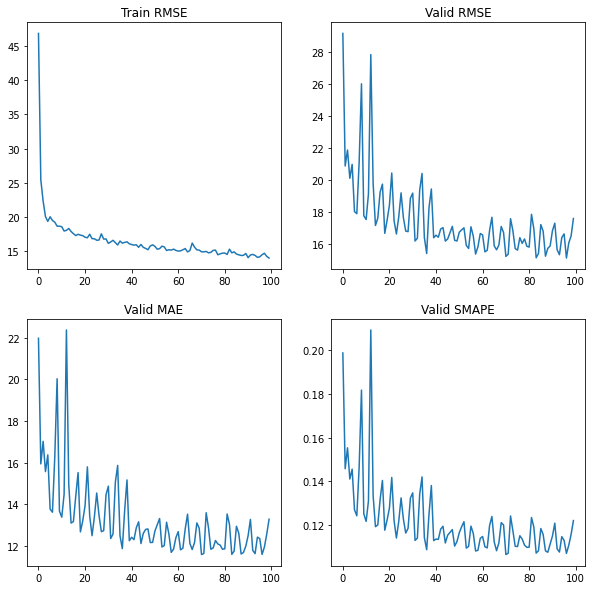

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].plot(history['Train Loss'])
axs[0, 0].title.set_text('Train RMSE')
axs[0, 1].plot(history['Valid RMSE'])
axs[0, 1].title.set_text('Valid RMSE')
axs[1, 0].plot(history['Valid MAE'])
axs[1, 0].title.set_text('Valid MAE')
axs[1, 1].plot(history['Valid SMAPE'])
axs[1, 1].title.set_text('Valid SMAPE')